# Info

Setting up the model to recreate the oscillating basin from the non-hydrostatic manual <br>
[Link to the manual](https://oss.deltares.nl/documents/4142077/4199062/non-hydrostatic_report_draft.pdf/eadc1aff-6e19-6e82-2747-3c11c30457ee?t=1624871720408)

In [1]:
# import default modules
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D 
from matplotlib import cm
import sys
import os
import subprocess
from matplotlib.animation import FuncAnimation

# Set global constants
PI = np.pi

# method to import xbtools with try routine
try:
    import xbTools
except ImportError:
    print('**no xbTools installation found in environment, adding parent path of notebook to see if it works')
    sys.path.append(r"..\..\..\xbeach-toolbox")

**no xbTools installation found in environment, adding parent path of notebook to see if it works


In [2]:
## import xbeach tools
#sys.path.append(os.path.abspath(os.path.join('..' )))

from xbTools.grid.creation import xgrid, ygrid
from xbTools.grid.extension import seaward_extend
from xbTools.xbeachtools import XBeachModelSetup
from xbTools.general.wave_functions import offshore_depth
from xbTools.xbeachpost import XBeachModelAnalysis

### Import library functions

In [3]:
sys.path.append(r"..\..\..\xBeach_Tutorial_Models")

from lib.solitary_funcs import (calc_L_scaling, calc_wave_speed, calc_surface_elevation,
                                calc_u_vel, calc_v_vel, calc_depth_average_u)


### Define the model parameters

In [59]:
# Define model parameters
nx = 16000
model_time = 250

# Define paramters for analytical solution
epsilon = 0.1
g  = 9.81
d0 = 1.0


### Calc the analytical solution

In [60]:
# Model parameters
# The model domain length and simulation time also change with the incident wave height

L_sol = calc_L_scaling(epsilon, delta_scaling=1/20) # Length of the solitary wave
model_length = 100 * L_sol                             # Length of the domain
x0 = -2 * L_sol                                     # Initial x-offset

c = calc_wave_speed(g, epsilon, d0)

print("Scaling wave lengths: {}".format(L_sol))
print("Channel Lengths: {}".format(model_length))
print("x0 Locations: {}".format(x0))
print("Wave speed: {}".format(c))

Scaling wave lengths: 7.953925506456178
Channel Lengths: 795.3925506456178
x0 Locations: -15.907851012912356
Wave speed: 3.2841662030181356


In [61]:
# Set the index for the current wave
index = 0

# Select the time arr
time = np.linspace(0, model_time, 1000)

x_location = 0.0
# Calc the x velocity
u_vel = calc_u_vel(epsilon, x0 = x0, x = x_location, y = d0, t = time, g = g, d0 = d0)

# Calc the y velocity
v_vel = calc_v_vel(epsilon, x0 = x0, x = x_location, y = d0, t = time, g = g, d0 = d0)

# Calc the water surface elevation
eta = calc_surface_elevation(epsilon, x0, x= x_location, t = time, g = g, d0 = d0)

# Calc the average u velocity
u_avg = calc_depth_average_u(epsilon, x0, x = x_location, t = time, g = g, d0 = d0)

### Generate the boun_U.bcf file

In [62]:
file_name =  "boun_U.bcf"

# xBeach only wants the water surface height pertubation not the actual height
data = np.column_stack((time, u_avg, eta - d0))
# Write the header and the data to a file
with open(file_name, 'w') as file:
    file.write("vector\n")
    file.write("3\n")
    file.write("t U Z\n")
    np.savetxt(file, data, delimiter=' ', fmt='%10.8f')


print("Data written to {}".format(file_name))

Data written to boun_U.bcf


### Data
Generate and plot the bathymetry

In [63]:
# Define your array
xgr = np.linspace(0, model_length, nx+1)

# Specify the filename
filename = 'x.grd'

# Open the file in write mode
with open(filename, 'w') as file:
    # Write the elements of the xgr to the file separated by spaces
    file.write(' '.join(map(str, xgr)) + '\n')

print(f"xgr values have been written horizontally to {filename}")


xgr values have been written horizontally to x.grd


In [64]:
floor_depth = 0.0

# Define your array
array = np.ones(nx+1) * floor_depth

# Specify the filename
filename = 'bed.dep'

# Open the file in write mode
with open(filename, 'w') as file:
    # Write the elements of the array to the file separated by spaces
    file.write(' '.join(map(str, array)) + '\n')

print(f"Array values have been written horizontally to {filename}")

Array values have been written horizontally to bed.dep


In [65]:
def get_script_directory():
    try:
        # This will work if the script is run directly
        script_path = os.path.abspath(__file__)
    except NameError:
        # This will work in an interactive environment like Jupyter
        script_path = os.path.abspath('')
    
    return script_path

# Get the folder of the current script
model_dir = get_script_directory()

print("Model directory is: {}".format(model_dir))

Model directory is: c:\ERDC\tutorial_models\solitary_wave\2_sol_wave_nx_16000_tstop_250_CFL_075_2_layer_animation


In [66]:
# Specify the path to your batch file
batch_file = os.path.join(model_dir, r"run_model.bat")

# Run the batch file
try:
    subprocess.run(batch_file, check=True, shell=True)
    print(f"Batch file '{batch_file}' executed successfully.")
except subprocess.CalledProcessError as e:
    print(f"An error occurred while executing the batch file: {e}")

Batch file 'c:\ERDC\tutorial_models\solitary_wave\2_sol_wave_nx_16000_tstop_250_CFL_075_2_layer_animation\run_model.bat' executed successfully.


In [67]:
results = XBeachModelAnalysis(fname = "foo", 
                              model_path=model_dir)

In [68]:
results.set_save_fig(False)
results.set_plot_localcoords(False)
results.set_plot_km_coords(False)

loading variable zs from file
loading variable zb from file
Variable already loaded
Variable already loaded
Variable already loaded
Variable already loaded
Variable already loaded
Variable already loaded
Variable already loaded
Variable already loaded
Variable already loaded
Variable already loaded
Variable already loaded
Variable already loaded


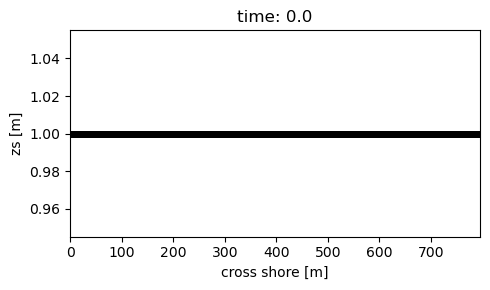

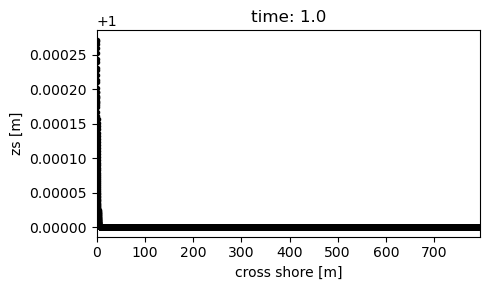

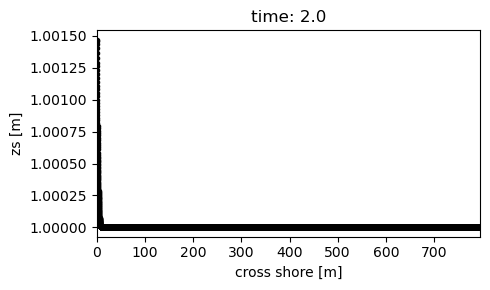

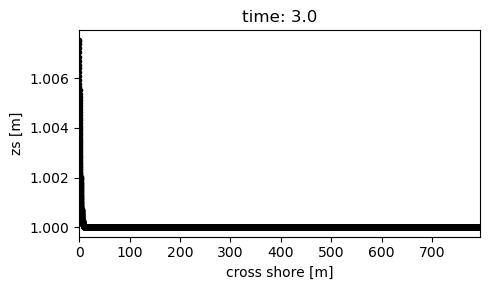

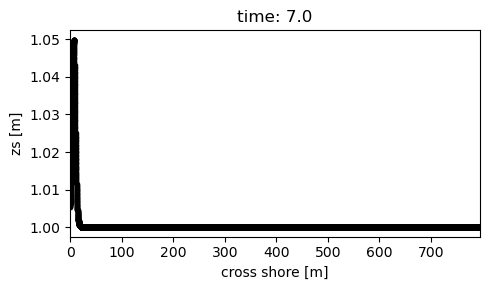

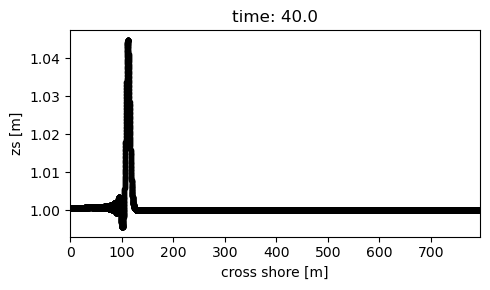

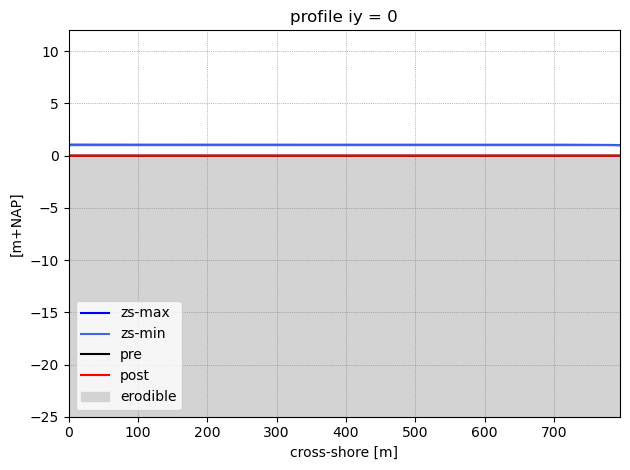

In [69]:
indices = [0, 10, 20, 30, 70, 400]

for index in indices:
    fig, ax = results.fig_cross_var('zs', index, iy=0, coord=None, plot_ref_bathy=False, zmin=-1)

fig, ax = results.fig_profile_change(iy=0)

In [70]:
time = results.var["globaltime"]
zs = results.var["zs"]

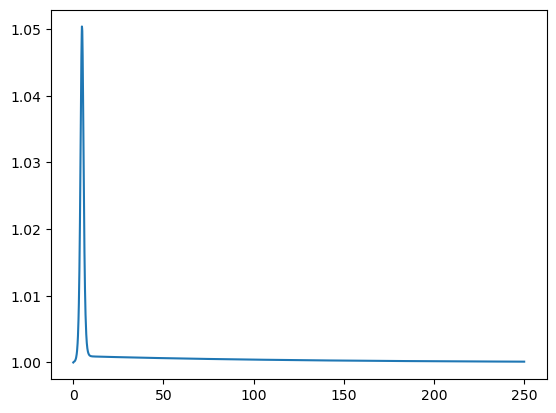

In [71]:
zs_0 = results.var["zs"][:, 0, 0]
plt.plot(time, zs_0)

### Making an animation

In [72]:
xgr

array([0.00000000e+00, 4.97120344e-02, 9.94240688e-02, ...,
       7.95293127e+02, 7.95342839e+02, 7.95392551e+02])

In [73]:
results.var["zs"].shape

(2501, 1, 16001)

In [74]:
results.var["zs"][0, 0, :]

masked_array(data=[1., 1., 1., ..., 1., 1., 1.],
             mask=False,
       fill_value=1e+20)

In [75]:
time

masked_array(data=[0.000e+00, 1.000e-01, 2.000e-01, ..., 2.498e+02,
                   2.499e+02, 2.500e+02],
             mask=False,
       fill_value=1e+20)

MovieWriter PillowWriter unavailable; using Pillow instead.


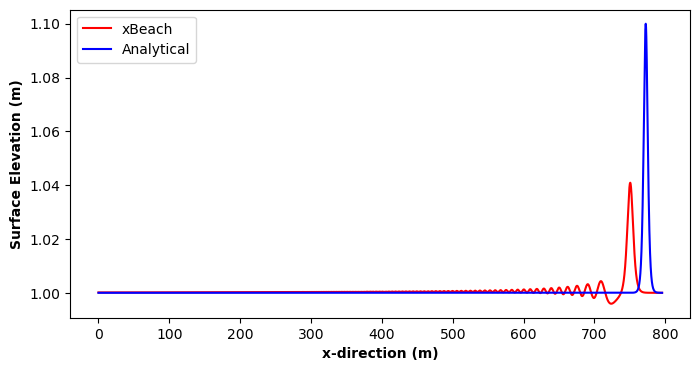

In [78]:
# Make an animation of the analytical vs. xbeach solution
fig = plt.figure(figsize = (8, 4))

ax = fig.add_subplot()

def update_plot(index):
    """
    Update the next frame of the animation
    """
    # Calc the analytical solution
    analytical_zs = calc_surface_elevation(epsilon, x0, xgr, time[index], g, d0)
    ax.clear()

    zs = results.var["zs"][index, 0, :] 
    ax.plot(xgr, zs, color = "red", label = "xBeach")
    ax.plot(xgr, analytical_zs, color = "blue", label = "Analytical")
    ax.set_xlabel("x-direction (m)", weight = "bold")
    ax.set_ylabel("Surface Elevation (m)", weight = "bold")
    ax.legend()

ani = FuncAnimation(fig, update_plot, frames = list(range(0, results.var["zs"][:, 0, 0].size - 1, 100)),
                    interval = 100)

ani.save("boundary_solitary_wave.gif", writer = "PillowWriter")
plt.show()

## Flow Boundary Conditions

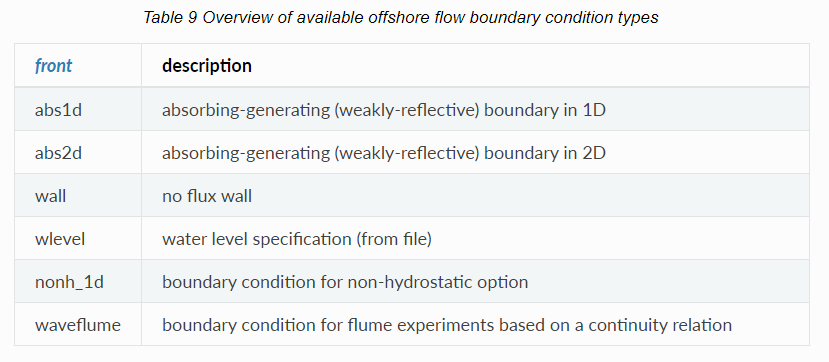

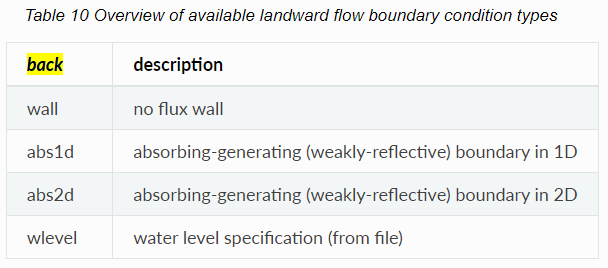

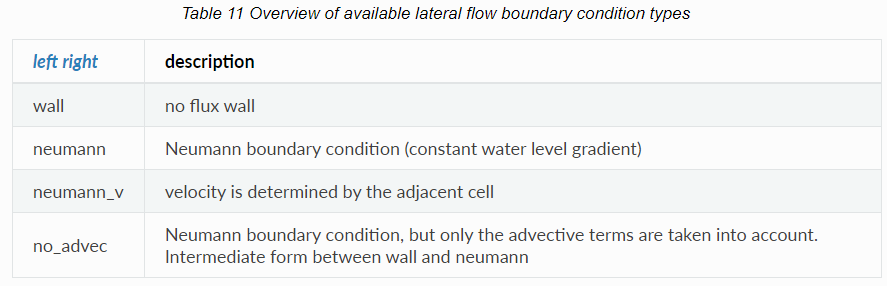

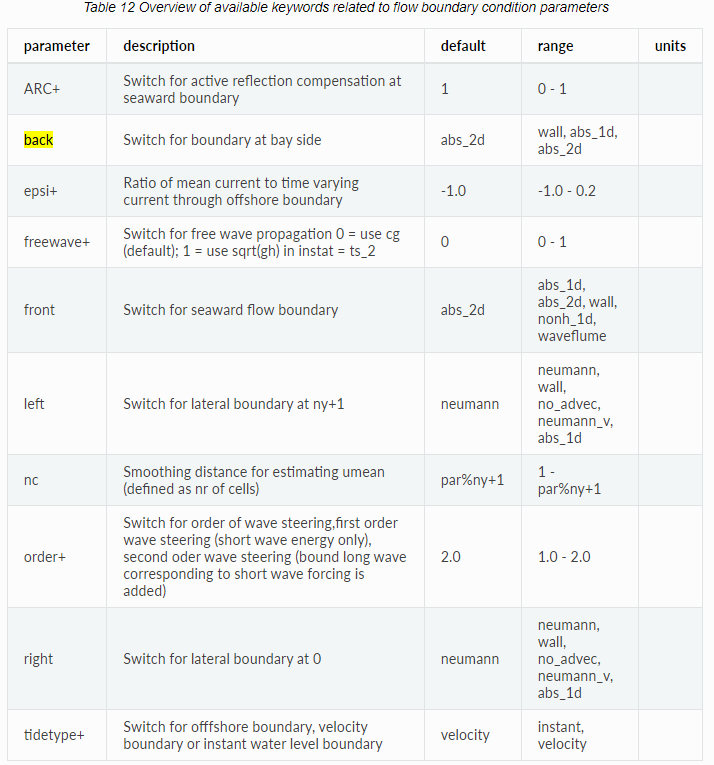